In [125]:
import sys
sys.path.append('../')

import pyarrow.parquet as pq

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
import torch
import torch.nn as nn
import numpy as np
from models.transformer_utils import Transformer

In [127]:
bulk_df = pq.read_table("~/Downloads/ztf_000858_zg_c01_q1_dr19.parquet").to_pandas()
bulk_df.head()

,objectid,filterid,fieldid,rcid,objra,objdec,nepochs,hmjd,mag,magerr,clrcoeff,catflags
0,858101100000000,1,858,0,121.166801,74.119148,181,"[58247.17837, 58347.49742, 58362.49149, 58368....","[20.790735, 20.31993, 20.606007, 21.471548, 21...","[0.20726836, 0.15888518, 0.18998587, 0.2709626...","[-0.08939283, -0.009556137, -0.006476993, -0.1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,858101100000001,1,858,0,119.970047,74.188736,610,"[58207.2526, 58207.2744, 58210.25232, 58229.15...","[16.1671, 16.162312, 16.10719, 16.154564, 16.1...","[0.014392191, 0.014376102, 0.014196091, 0.0143...","[-0.082320735, -0.08643703, -0.048796955, -0.0...","[0, 0, 0, 0, 32768, 0, 0, 0, 0, 32768, 0, 0, 0..."
2,858101100000002,1,858,0,120.869438,74.136711,610,"[58207.25263, 58207.27442, 58210.25234, 58229....","[16.092796, 16.05233, 16.037151, 16.08971, 16....","[0.014150625, 0.014026101, 0.01398062, 0.01414...","[-0.082320735, -0.08643703, -0.048796955, -0.0...","[0, 0, 0, 0, 32768, 0, 0, 0, 0, 32768, 0, 0, 0..."
3,858101100000003,1,858,0,121.366310,74.105324,598,"[58207.25264, 58207.27444, 58210.25236, 58229....","[17.77512, 17.661259, 17.747467, 17.815546, 17...","[0.02695156, 0.02533685, 0.026544018, 0.027565...","[-0.082320735, -0.08643703, -0.048796955, -0.0...","[0, 0, 0, 0, 32768, 0, 0, 0, 0, 32768, 0, 0, 0..."
5,858101100000005,1,858,0,121.104126,74.121140,379,"[58244.2015, 58247.17837, 58255.19753, 58346.4...","[20.145699, 20.32862, 20.048012, 20.142803, 19...","[0.14019924, 0.159865, 0.13053155, 0.13990413,...","[-0.0957851, -0.08939283, -0.0756015, -0.03298...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [128]:
filtered_df = bulk_df[bulk_df['mag'].apply(lambda x: len(x) >= 5)]

n_max_obs = 100
# For entries with > 200 observations, randomly sample 200 observations (hmjd, mag, and magerr with same sample) from the light curve
# Pad the entries to 200 observations with zeros and create a mask array
mask_list = [] 
for i in filtered_df.index:
    if len(filtered_df.loc[i]['mag']) > n_max_obs:
        mask = np.ones(n_max_obs, dtype=bool)
        mask_list.append(mask)
        indices = np.random.choice(len(filtered_df.loc[i]['mag']), n_max_obs)
        filtered_df.at[i, 'hmjd'] = filtered_df.loc[i]['hmjd'][indices]

        # Sort the observations by time
        sorted_indices = np.argsort(filtered_df.loc[i]['hmjd'])
        filtered_df.at[i, 'hmjd'] = filtered_df.loc[i]['hmjd'][sorted_indices]
        filtered_df.at[i, 'mag'] = filtered_df.loc[i]['mag'][sorted_indices]
        filtered_df.at[i, 'magerr'] = filtered_df.loc[i]['magerr'][sorted_indices]
    else:
        mask = np.zeros(n_max_obs, dtype=bool)
        mask[:len(filtered_df.loc[i]['mag'])] = True
        mask_list.append(mask)
        
        # Pad the arrays with zeros
        filtered_df.at[i, 'mag'] = np.pad(filtered_df.loc[i]['mag'], (0, n_max_obs - len(filtered_df.loc[i]['mag'])), 'constant')
        filtered_df.at[i, 'magerr'] = np.pad(filtered_df.loc[i]['magerr'], (0, n_max_obs - len(filtered_df.loc[i]['magerr'])), 'constant')
        filtered_df.at[i, 'hmjd'] = np.pad(filtered_df.loc[i]['hmjd'], (0, n_max_obs - len(filtered_df.loc[i]['hmjd'])), 'constant')

In [129]:
len(filtered_df)

91

In [130]:
import math

class TimePositionalEncoding(nn.Module):

    def __init__(self, d_emb):
        """
        Inputs
            d_model - Hidden dimensionality.
        """
        super().__init__()
        self.d_emb = d_emb

    def forward(self, t):
        pe = torch.zeros(t.shape[0], t.shape[1], self.d_emb).to(t.device)  # (B, T, D)
        div_term = torch.exp(torch.arange(0, self.d_emb, 2).float() * (-math.log(10000.0) / self.d_emb))[None, None, :].to(t.device)  # (1, 1, D / 2)
        t = t.unsqueeze(2)  # (B, 1, T)
        pe[:, :, 0::2] = torch.sin(t * div_term)  # (B, T, D / 2)
        pe[:, :, 1::2] = torch.cos(t * div_term)  # (B, T, D / 2)
        return pe  # (B, T, D)

class TransformerWithTimeEmbeddings(nn.Module):
    """
    Transformer for classifying sequences
    """

    def __init__(self, n_out=1, **kwargs):
        """
        :param emb: Embedding dimension
        :param heads: nr. of attention heads
        :param depth: Number of transformer blocks
        :param seq_length: Expected maximum sequence length
        :param num_classes: Number of classes.
        :param max_pool: If true, use global max pooling in the last layer. If false, use global
                         average pooling.
        """
        super().__init__()
        
        self.embedding_mag = nn.Linear(in_features=1, out_features=kwargs['emb'])
        self.embedding_t = TimePositionalEncoding(kwargs['emb'])
        self.transformer = Transformer(**kwargs)
        self.projection = nn.Linear(in_features=kwargs['emb'], out_features=n_out)

    def forward(self, x, t, mask=None):
        """
        :param x: A batch by sequence length integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """
        t = t - t[:, 0].unsqueeze(1)
        t_emb = self.embedding_t(t)
        x = self.embedding_mag(x) + t_emb
        x = self.transformer(x, mask)
        x = self.projection(x)

        return x

transformer = TransformerWithTimeEmbeddings(n_out=1, emb=128, heads=2, depth=2)
pe = TimePositionalEncoding(d_emb=128)

In [131]:
import pytorch_lightning as pl

In [132]:
class MaskedLightCurveEncoder(pl.LightningModule):
    def __init__(self, f_mask=0.2, optimizer_kwargs={"weight_decay": 1e-4}, lr=1e-3):
        super().__init__()

        self.optimizer_kwargs = optimizer_kwargs
        self.lr = lr
        self.f_mask = f_mask

        self.net = TransformerWithTimeEmbeddings(n_out=1, emb=128, heads=2, depth=4)

    def forward(self, x, t, mask=None):
        x = x[..., None]
        x = self.net(x, t, mask)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, **self.optimizer_kwargs)
        return {"optimizer": optimizer}

    def masked_pred(self, x, t, padding_mask, f_mask=0.15):
        # Get number of observations using padding mask
        n_obs = padding_mask.sum(dim=1)

        n_obs_to_keep = torch.round((1 - f_mask) * n_obs).int()
        mask = torch.zeros_like(x).bool()  # Default to full mask
        mask_pred = torch.zeros_like(x).bool()
        
        # Randomly keep a contiguous set of observations
        for i in range(x.shape[0]):
            
            start = torch.randint(0, n_obs[i] - n_obs_to_keep[i] + 1, (1,)).item()
            end = start + n_obs_to_keep[i]
            
            mask[i, start:end] = True

            mask_pred[i, end:] = True
            mask_pred[i, :start] = True
        
        x_pred = self(x, t, mask)[..., 0]
        return x[mask_pred], x_pred[mask_pred]
    
    def training_step(self, batch, batch_idx):
        x, t, padding_mask = batch
        x, x_pred = self.masked_pred(x, t, padding_mask, f_mask=self.f_mask)
        loss = nn.MSELoss()(x, x_pred)
        self.log("train_loss", loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t, padding_mask = batch
        x, x_pred = self.masked_pred(x, t, padding_mask, f_mask=self.f_mask)
        loss = nn.MSELoss()(x, x_pred)
        self.log("val_loss", loss, on_epoch=True)
        return loss

In [133]:
mag = filtered_df['mag'].array
magerr = filtered_df['magerr'].array
hmjd = filtered_df['hmjd'].array

# Convert to torch tensors
mag = torch.Tensor(mag)
magerr = torch.Tensor(magerr)
hmjd = torch.Tensor(hmjd)
mask = torch.Tensor(mask_list).to(torch.bool)

# Standardize mag and magerr
mag_mean = mag.mean()
mag_std = mag.std()
mag = (mag - mag_mean) / mag_std
magerr = magerr / mag_std

In [134]:
mlce = MaskedLightCurveEncoder()

In [135]:
# mag_dummy = mag[:1]
# print((mlce(mag_dummy, hmjd[:1], mask[:1])[..., 0] * mask[:1]).sum())

# mag_dummy[mag_dummy == 0] = 12.
# print((mlce(mag_dummy, hmjd[:1], mask[:1])[..., 0] * mask[:1]).sum())

In [136]:
from torch.utils.data import TensorDataset, DataLoader, random_split

val_fraction = 0.
batch_size = 64
n_samples_val = int(val_fraction * mag.shape[0])

dataset = TensorDataset(mag, hmjd, mask)

dataset_train, dataset_val = random_split(dataset, [mag.shape[0] - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)

In [137]:
trainer = pl.Trainer(max_epochs=30, accelerator='cpu')
trainer.fit(model=mlce, train_dataloaders=train_loader,);

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniforge/base/envs/cfm/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cfm/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type                          | Params
-------------------------------------------------------
0 | net  | TransformerWithTimeEmbeddings | 1.1 M 
-------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.220     Total estimated model params size (M

Training: 0it [00:00, ?it/s]

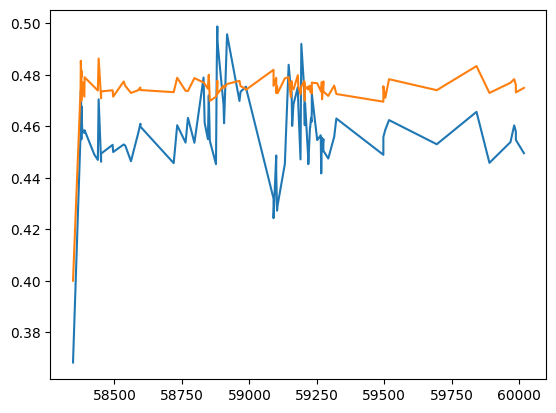

In [ ]:
import matplotlib.pyplot as plt

ii = 567

mask_tofill = mask[ii:ii + 1].clone()

# mask_tofill[:, 0:0] = False

plt.plot(hmjd[ii], mlce(mag[ii:ii + 1], hmjd[ii:ii + 1], mask_tofill)[0, :, 0].detach().numpy())
plt.plot(hmjd[ii], mag[ii:ii + 1].detach().numpy()[0])